In [39]:
!python -m spacy download es_core_news_md

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     --------------------------------------- 0.1/42.3 MB 787.7 kB/s eta 0:00:54
     --------------------------------------- 0.1/42.3 MB 939.4 kB/s eta 0:00:45
     --------------------------------------- 0.1/42.3 MB 944.1 kB/s eta 0:00:45
     --------------------------------------- 0.2/42.3 MB 833.5 kB/s eta 0:00:51
     --------------------------------------- 0.2/42.3 MB 833.5 kB/s eta 0:00:51
     --------------------------------------- 0.2/42.3 MB 833.5 kB/s eta 0:00:51
     --------------------------------------- 0.2/42.3 MB 687.0 kB/s eta 0:01:02
     --------------------------------------- 0.2/42.3 MB 627.5 kB/s eta 0:01:08
     --------------------------------------- 0.3/42.3 MB 606.6 kB/s eta 0:01:10
     --------------------------------------- 0.3/42.3 MB 6

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import time


# Paper Reviews


https://archive.ics.uci.edu/dataset/410/paper+reviews

The data set consists of paper reviews sent to an international conference mostly in Spanish (some are in English). It has a total of N = 405 instances evaluated with a 5-point scale ('-2': very negative, '-1': negative, '0': neutral, '1': positive, '2': very positive), expressing the reviewer's opinion about the paper and the orientation perceived by a reader who does not know the reviewer's evaluation (more details in the attributes' section). The distribution of the original scores is more uniform in comparison to the revised scores. This difference is assumed to come from a discrepancy between the way the paper is evaluated and the way the review is written by the original reviewer.

The data set is stored in JSON format, the structure is as follows:
Paper: {
 papers have an associated timespan and a paper ID, each paper contains some reviews. The reviews have their own ID, the review text, the remarks (which can be empty), the language of the review, its orientation and evaluation.



Variable Information

1. Timespan (datetime): A date associated with the year of conference, which in turn corresponds with the time the review was written. The data set includes four years of reviews worth of conferences.
2. Paper ID (integer):  This number identifies each individual paper from a given conference. The data set has 172 different papers.
3. Preliminary decision (label): The preliminary decision of acceptance or rejection of a paper taken by the conference committee.
4. Review ID (integer: A serial number identifier for each review as a correlative with respect to each individual paper. (e.g. the second review of some paper would correspond to the number $2$). The data set has a total of 405 reviews. Most papers have 2 reviews each.
5. Text (text): Comments and detailed review of the paper. This is read by the authors and the editing commission of the conference. The editors determine if the paper should be published or not depending on the reviews. There are $6$ instances of empty reviews.
6. Remarks (text): Additional comments that can be read only by the editing commission of the conference. This is used in conjunction with the previous attribute to determine if the paper should be published. This is an optional attribute. Whenever it is possible it is concatenated at the end of the main body of the review. Some reviews do not have remarks, this is indicated with an empty string ''.
7. Language (text): Language corresponding to the review (it may be English or Spanish). In this case the majority of the reviews are in Spanish, with only $17$ instances of English reviews.
8. Orientation (integer from -2 to 2): Review classification defined by the authors of this study, according to the 5-point scale previously described, obtained through the authors' systematic judgement of each review. This attribute represents the subjective perception of each review (i.e. how negative or positive the review is perceived when someone reads it).
9. Evaluation (integer from -2 to 2): Review classification as defined by the reviewer, according to the 5-point scale previously described. This attribute represents the real evaluation given to the paper, as determined by the reviewers.
10. Confidence (integer from 1 to 5): Value describing the confidence of the reviewer, a higher value denotes more confidence, while a lower value indicates less confidence.

In [90]:

# Load the JSON file
with open('reviews.json', encoding='utf-8') as f:
    raw_data = json.load(f)

# Normalize with distinct prefixes
df = pd.json_normalize(
    raw_data['paper'],
    record_path='review',
    meta=['id', 'preliminary_decision'],
    record_prefix='',
    meta_prefix='paper_'
)

# Rename columns for clarity (optional)
df = df.rename(columns={
    'paper_id': 'paper_id',
    'review_id': 'review_id',
    'paper_preliminary_decision': 'preliminary_decision'
})

df


,confidence,evaluation,id,lan,orientation,remarks,text,timespan,paper_id,preliminary_decision
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05,1,accept
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05,1,accept
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05,1,accept
3,4,2,1,es,1,,Se explica en forma ordenada y didáctica una e...,2010-07-05,2,accept
4,4,2,2,es,0,,,2010-07-05,2,accept
...,...,...,...,...,...,...,...,...,...,...
400,5,-1,1,es,-2,,El trabajo pretende ofrecer una visión del uso...,2015-07-05,170,reject
401,4,-1,2,es,-1,,El paper está bien escrito y de fácil lectura....,2015-07-05,170,reject
402,4,-1,1,es,0,,Observación de fondo: No se presenta un ejemp...,2015-07-05,171,accept
403,3,1,2,es,-1,,Se propone un procedimiento para elaborar máqu...,2015-07-05,171,accept


In [91]:
df.columns

Index(['confidence', 'evaluation', 'id', 'lan', 'orientation', 'remarks',
       'text', 'timespan', 'paper_id', 'preliminary_decision'],
      dtype='object')

In [92]:
columns=['confidence', 'evaluation', 'id', 'lan', 'preliminary_decision']

# Distribución de valores únicos por variables
columns=['confidence', 'evaluation', 'id', 'lan', 'preliminary_decision']

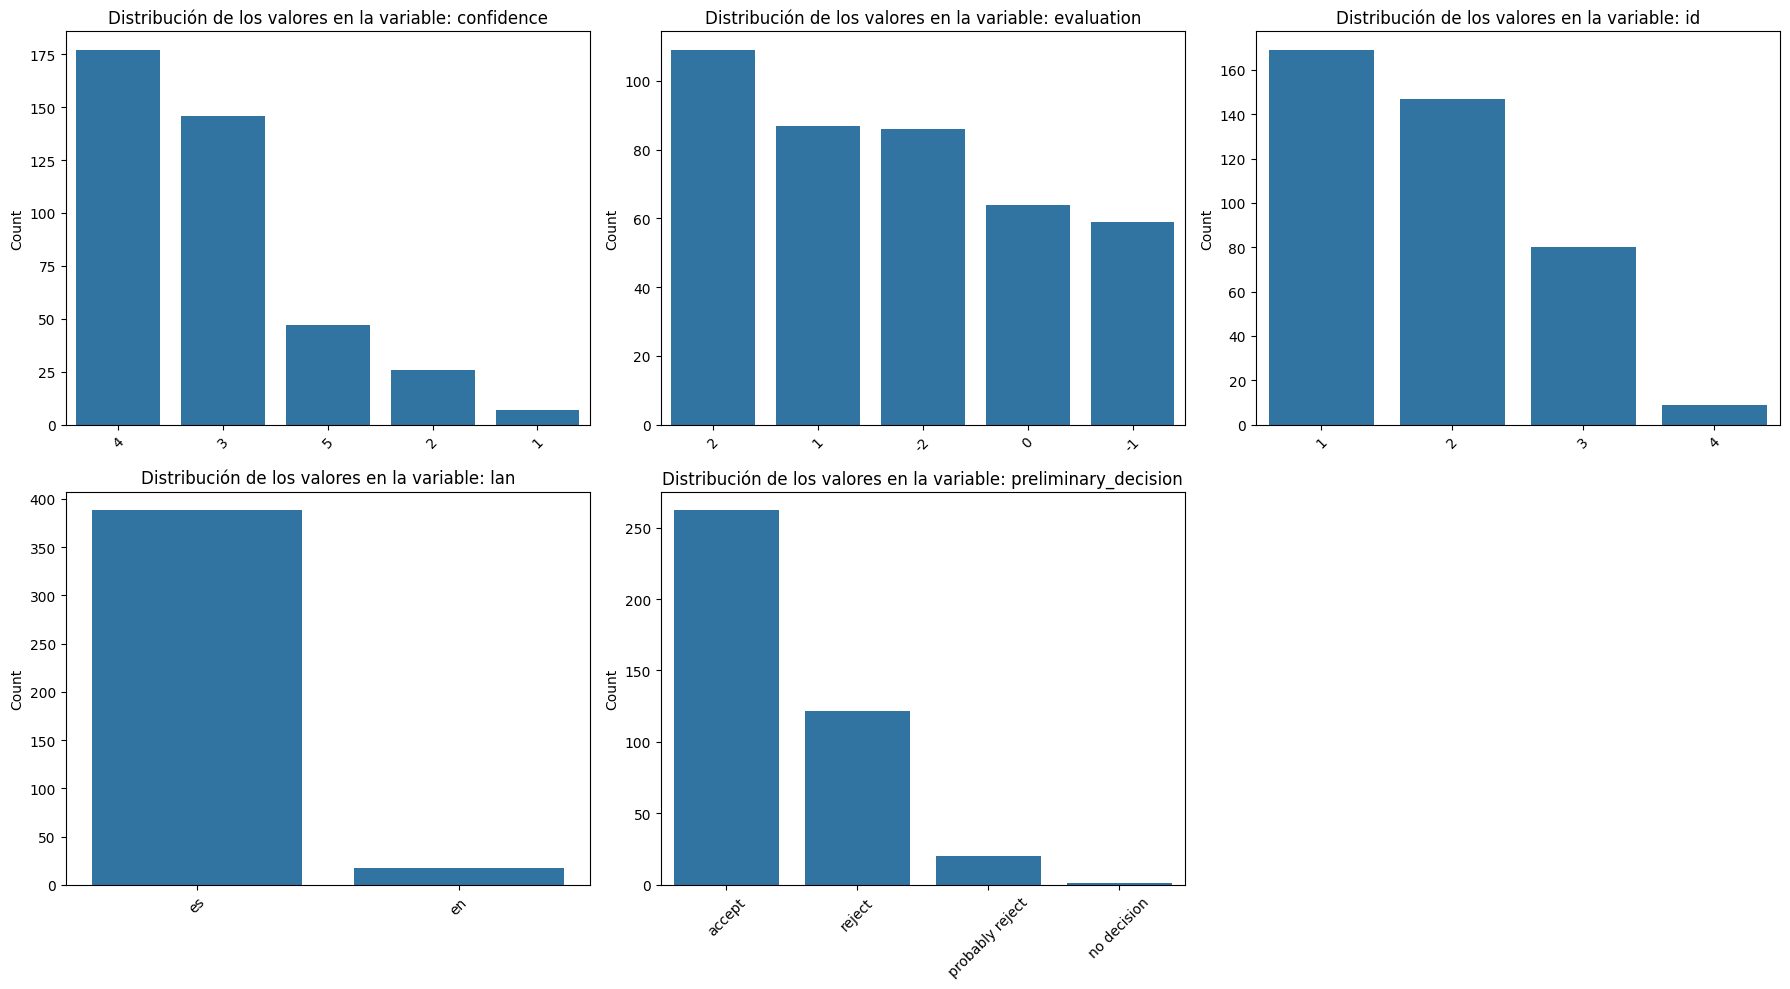

In [93]:


# Assuming columns has exactly 6 columns or fewer (adjust rows/cols accordingly)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(columns):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribución de los valores en la variable: {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# If fewer than 6 plots, hide the unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [94]:
df

,confidence,evaluation,id,lan,orientation,remarks,text,timespan,paper_id,preliminary_decision
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05,1,accept
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05,1,accept
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05,1,accept
3,4,2,1,es,1,,Se explica en forma ordenada y didáctica una e...,2010-07-05,2,accept
4,4,2,2,es,0,,,2010-07-05,2,accept
...,...,...,...,...,...,...,...,...,...,...
400,5,-1,1,es,-2,,El trabajo pretende ofrecer una visión del uso...,2015-07-05,170,reject
401,4,-1,2,es,-1,,El paper está bien escrito y de fácil lectura....,2015-07-05,170,reject
402,4,-1,1,es,0,,Observación de fondo: No se presenta un ejemp...,2015-07-05,171,accept
403,3,1,2,es,-1,,Se propone un procedimiento para elaborar máqu...,2015-07-05,171,accept


In [98]:
#df['preliminary_decision'] = df['preliminary_decision']=='no decision'
#df['preliminary_decision']=='probably reject'

df = df[(df['preliminary_decision'] == 'accept') | (df['preliminary_decision'] == 'reject')]
#df_filtered = df[(df['status'] == 'Inactive') | (df['age'] < 18)]

In [99]:
df

,confidence,evaluation,id,lan,orientation,remarks,text,timespan,paper_id,preliminary_decision
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05,1,accept
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05,1,accept
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05,1,accept
3,4,2,1,es,1,,Se explica en forma ordenada y didáctica una e...,2010-07-05,2,accept
4,4,2,2,es,0,,,2010-07-05,2,accept
...,...,...,...,...,...,...,...,...,...,...
399,4,1,2,es,0,,El artículo tiene como objetivo brindar una ar...,2015-07-05,169,accept
400,5,-1,1,es,-2,,El trabajo pretende ofrecer una visión del uso...,2015-07-05,170,reject
401,4,-1,2,es,-1,,El paper está bien escrito y de fácil lectura....,2015-07-05,170,reject
402,4,-1,1,es,0,,Observación de fondo: No se presenta un ejemp...,2015-07-05,171,accept


In [100]:
df['text'][0]

'- El artículo aborda un problema contingente y muy relevante, e incluye tanto un diagnóstico nacional de uso de buenas prácticas como una solución (buenas prácticas concretas). - El lenguaje es adecuado.  - El artículo se siente como la concatenación de tres artículos diferentes: (1) resultados de una encuesta, (2) buenas prácticas de seguridad, (3) incorporación de buenas prácticas. - El orden de las secciones sería mejor si refleja este orden (la versión revisada es #2, #1, #3). - El artículo no tiene validación de ningún tipo, ni siquiera por evaluación de expertos.'

In [101]:
import spacy
nlp = spacy.load("es_core_news_md")

In [102]:
def preprocesar(texto):
    print(texto)
    # Cambia a minúsculas
    texto = texto.lower()
    # Remueve la puntuación.
    texto = re.sub(r"[^\w\s]", "", texto)
    doc = nlp(texto)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

In [103]:
df['texto_procesado'] = df['text'].apply(preprocesar)

- El artículo aborda un problema contingente y muy relevante, e incluye tanto un diagnóstico nacional de uso de buenas prácticas como una solución (buenas prácticas concretas). - El lenguaje es adecuado.  - El artículo se siente como la concatenación de tres artículos diferentes: (1) resultados de una encuesta, (2) buenas prácticas de seguridad, (3) incorporación de buenas prácticas. - El orden de las secciones sería mejor si refleja este orden (la versión revisada es #2, #1, #3). - El artículo no tiene validación de ningún tipo, ni siquiera por evaluación de expertos.
El artículo presenta recomendaciones prácticas para el desarrollo de software seguro. Se describen las mejores prácticas recomendadas para desarrollar software que sea proactivo ante los ataques, y se realiza un análisis de costos de estas prácticas en desarrollo de software. Todo basado en una revisión de prácticas propuestas en la bibliografía y su contraste con datos obtenidos de una encuesta en empresas. Finalmente s

El tema es interesante y está bien estructurado en lo que se refiere a diseño de la propuesta.  El tema trata de un enfoque para la mejora, sin embargo solo establece una propuesta de arquitectura, centrándose en el diseño, y no indica cómo se evaluará o medirá esta mejora para los SDW, se recomienda agregar métricas u otros aspectos para ello. No entrega muchos detalles, se recomienda aumentar el nro. de páginas para sí mejorar este aspecto. No hay muchas referencias bibliográficas a trabajos o esfuerzos relacionados sobre el tema.
De alto perfil técnico, es un aporte a la temática.  Demasiado conciso, podría extenderse en el cómo (sobretodo desde el aporte fuzzy).
The paper describes an experience concerning the automated inspection of spectra for the Pipeline Hubble Legacy Archive Grism data.  Comments:  In the conclusions the authors say that "We have identified two classes of flawed spectra which were not picked up by the automatic classification because of their very small number

El artículo presenta el desarrollo de una solución al problema de analizar tendencias en el desembarco de especies marinas en el borde costero chileno, utilizando herramientas de inteligencia de negocios.  a) aspectos de forma  1. la versión en inglés del título y el resumen del artículo contiene errores gramaticales, de redacción, y de estilo.  2. Uso de mayúsculas: chile --> Chile servicio nacional de pesca --> Servicio Nacional de Pesca kettle --> Kettle tabla 1 --> Tabla 1 api --> API etc.  3. Figura 2 no es referenciada Esta figura muestra --> La Figura 10 muestra  4. parráfo despues de la Figura 1 esta escrito en 1 columna. debe ser en 2 columnas  5. formato no concuerda totalmente con el formato Infonor.  b) aspectos de fondo   1. El artículo no reporta resultados de investigación. Se trata de una aplicación de técnicas de BI para proveer soporte de análisis en línea de datos.  2. Es débil en cuanto a background de procesos y técnicas utilizados. Aunque se listan 12 referencias,

- La herramienta APARD - La temática asociada a requerimientos y fábrica de software es interesante  - No está detallado el caso práctico que considere el uso APARD con sus ventajas y limitaciones - La sección que explica la implementación de la solución APARD debe ser mejorada - Mejorar conclusiones - La presentación:  con errores ortográficos y de redacción, escrito en primera persona, figuras con letras muy pequeñas, color blanco de letras en figuras la hacen poco legible, referencias escritas de diferente forma, etc. - Se recomienda no utilizar Wikipedia como referencia para un artículo científico. - Falta autor en referencias 6, falta nombre de tema en referencia 13 - Referencia 7 está escrita con autor de manera diferente a las otras y con título antes de autor. - Cambiar “Palabras claves” por “Palabras clave”. - De acuerdo a formato, poner como mínimo 5 palabras clave. - Pone referencia en otro formato, ejemplo, Greenfield y Short(2003) - Hay mucho detalle de tecnologías y herra

NO ME ENCUENTRO CAPACITADO PARA EFECTUAR ESTA REVISION. ESTA MUY LEJOS DE MI ESPECIALIZACION.

La novedad del tema a tratar hace del artículo una investigación interesante. Tiene una muy buena presentación y es fácil de leer, lo cual da un aspecto llamativo al tema. A pesar de ser un tema que incluye dos disciplinas muy distintas, han logrado sincronizar adecuadamente los conceptos de tal forma que la investigación es importante y aporta conocimiento desde la parte inicial del trabajo realizado, hasta las propias conclusiones Se recomienda a los autores seguir con el trabajo a fin de acabar otros aspectos relacionados con la salud pública.    Recomendaciones: Es indispensable mejorar la calidad de las figuras, existen algunas que es imposible visualizar, como es el caso de Figura 4, Figura 6, Figura 7 y Figura 8.
- Buena revisión de tendencias, tecnologías y estándares que podrían utilizarse para la implementación de sistemas de telemedicina. - Interesante caso práctico que hacen del s

Tema bien tratado técnicamente y en forma clara.  El tema solo muestra un manejo técnico sobre una herramienta, y no aporta algo novedoso. Se recomienda hacer una comparación en complejidad sobe las SQL con datos primitivos versus a datos XML, y abarcar otros aspectos como por ejemplo la mejora, etc.
Se ajusta al formato solicitado y se puede leer sin dificultad.  El artículo básicamente es un revisión de las herramientas Xpath, Xquery y SQL/XML en Oracle 10g, ilustrando su uso con varios ejemplos.  No hay un aporte, en ya sea nuevo conocimiento o aplicación de la tecnología para resolver un problema real.  No hay resultados de investigación que mostrar ni discutir.
El articulo narra la experiencia del desarrollo de una solución robotizada para el problema industrial de reparación de motores eléctricos. En particular, el problema de realizar soldaduras de precisión de motores eléctricos mediante un brazo robótico. El artículo presenta aspectos prácticos del desarrollo de la solución, c

The paper introduces a segmentation procedure for breast tissue images using SVM.  General comments:  a) Concerning the proposed approach: The segmentation method introduced only considers local color/gray value information. Perhaps introducing other features related to the membrane's local (e.g. the membrane has symmetry properties that can be exploited) or global (e.g. continuity, approximately circular shape) properties may improve the segmentation results.  Feature selection is also a key component to improve performance. Use a feature selection procedure.  b) Concerning the experimentation: You should describe the experiments with sufficient detail so others can replicate them: a) Make your data publicly available b) Explain how you have selected the classifier's parameters (parameter selection in an SVM is critical and may improve notably the performance).  You should join Figs 10 and 9 in a single plot so we can better see the differences.  You only provide qualitative segmentat

Comentarios generales: • Se recomienda revisar todo el escrito ya que hay palabras de más o palabras escritas de manera equivocada por ejemplo: imcompletas, ítemes (pag 3);  quedebe (pag 4), del de (pag 5)… etc • Revisar el espaciado de las palabras • Revisar la numeración de la bibliografía ya que tiene que ser listada en el orden en que ésta aparece. • Revisar que el texto sea del mismo tamaño  (ejemplo: final primera columna página 1)  Comentarios por secciones  II SCRUM YSPEM • Referenciar la parte dedicada a SCRUM así como la figura ya que no es propia de los autores si no tomada de alguien más  III LEVANTAMIENTO DE REQUERIMIENTOS UTILIZANDO SPEM • Revisar el concepto de stakeholder o referenciar de que referencia utilizó ese concepto, por ejemplo incluyo los conceptos de stakeholder para CMMI. “Parte interesada (stakeholder) Un grupo o individuo que se ve afectado por o es de alguna manera responsable del resultado de una empresa” “Parte interesada (stakeholder) Un grupo o indivi

El documento intenta mostrar una evaluación de atributos de calidad de software basada en el estándar ISO 9126. El documento muestra una propuesta de una plantilla con una serie de preguntas para analizar la calidad de diferentes atributos de calidad de un producto software desarrollado. Sin embargo, el documento carece de estructura. La redacción es deficiente. En algunas partes del documento no se siguen los parámetros de formato exigidos en la guía de autores. Por ejemplo, el resumen (abstract) está centrado y según la guía del evento debe estar justificado. De la misma forma se presentan algunos párrafos del documento. En cuanto a la redacción, el documento es difícil de leer, faltan o están mal ubicados los signos de puntuación. Las palabras claves no coinciden como palabras claves del artículo. Faltan referencias bibliográficas que sustenten las afirmaciones que se hacen. A pesar de que la plantilla puede ser tan útil como intentan asegurar en el trabajo, es necesario buscar una 

Este artículo presenta para medir la calidad de los procesos de software. El título ya fue algo que me sorprendió. Existen miles de debates en qué se entiende por calidad en los procesos de software y los autores no concretan cuáles son la base de la que parten. Además, la clasificación que hacen en los apartados desde las etapas de desarrollo, los procesos de desarrollo es algo de lo que existen muchas alternativas en la literatura y los autores se centran en una que parecen dar o tomar como el referente más adecuado. La visión práctica en el caso concreto de INAPI sí que es de interés pero creo que hubiera sido más importante el decir porqué se aplican las cosas que intentar definir una visión global y como estándar de los conceptos con los que trabajo. Por otro lado, hay otras propuestas metodológicas para aplicar 9001 en el contexto del software. Creo que habría que potenciar de manera más adecuada el que se defienda qué aporta esta en realidad.
-	La propuesta es una buena iniciati

El trabajo "Un análisis empírico de las recomendaciones comerciales en los Sitios de Redes Sociales"  es de relevancia científica y actualidad. Los datos estudiados muestran resultados interesantes a partir de una muestra principalmente hispanoamericana. Deberían los autores seguir sus líneas futuras de investigación.
Los comentarios aparecen en el archivo adjunto
El  trabajo "Liderazgo en adopción de TI en PYMEs ¿Sólo el involucramiento del propietario importa?" explora a través de la metodología IA la relación entre involucramiento del propietario y el éxito de la TI en PYME. Si bien es un buen trabajo, el texto puede ser mejorado en algunos aspectos de forma y fondo: 1.	Los autores deben declarar el objetivo del estudio para facilitar la lectura del trabajo. 2.	Lamentablemente los autores cometen un error importante al colocar a  D&M como modelo de aceptación a nivel individual ("Otros modelos de aceptación a nivel individual incluyen: el modelo de DeLone y McLean (D&M) [5]"). De he

-	No existen bases científicas explicitas en este trabajo y su aporte a la práctica es nulo.
Este artículo propone un conjunto de medidas de cuantificación basadas en la triangulación de Delaunay de características de las huellas dactilares como principios para un esquema de indexación.  El trabajo se expone mayoritariamente claro y las propuestas y resultados son interesantes para el congreso. Cabe hacer notar los siguientes aspectos negativos o que no quedan claros en el trabajo:  - Cuidado con mezclar títulos en inglés y contenido en español (revisar) - Revisar la redacción de la conclusión   "siendo esta casa vez menor a medida" - De los resultados mostrados, sólo la tabla 2 realiza presenta un resultado comparativo con otras soluciones, por lo que otros gráficos deberían también incluirse en forma "comparativa" - No queda claro la eficiencia de la propuesta ni el tamaño de la bd, más bien parece pequeña en relación a la cantidad de huellas que se espera que un sistema real maneje.

Un buen trabajo que está en sintonía con el INFONOR. De hecho este trabajo da continuidad a uno presentado en el INFONOR 2012. Mi única ponderación es que la referencia [13] debería ser el artículo publicado y presentado en el INFONOR en vez de la página del INFONOR.
Este artículo presenta un  Sistema de Reservas de Productos Turísticos mediante Servicios WEB y Dispositivos Móviles. Son utilizadas herramientas de dominio público y el desempeño es verificado  usando simulación. Considerando que los modelos no son perfectos, sobre todo  por la dificultad de modelar el comportamiento  humano, la realización de un estudio de caso (un piloto en escala reducida), donde se pueda medir el beneficio real de la herramienta propuesta.
Falta un poco de claridad en la presentación del tema. En las conclusiones falta mostrar cual es el aporte del trabajo y motivo de la investigación
No hay contribución científica interesante ya que es la aplicación de modelamiento a un caso de estudio. A pesar de qu

El artículo describe un conjunto de técnicas de extracción de datos principalmente encontradas en herramientas ETL, menciona las redes sociales que en principio señala como fuentes de datos para un estudio, pero que definitivamente no aplica o al menos no muestra su aplicación y resultados, lo mismo ocurre con las bases de datos NoSQL que menciona pero que se observa y describe un trabajo con ellas.  Si bien es cierto que se trata de una revisión, más parece un material docente para impartir una clase introductoria de ETL. Yo sugeriría aprovechar esta revisión preliminar para proponer una metodología de trabajo en redes sociales, además de establecer los pasos a seguir en este metodología para una extracción eficiente de datos desde los repositorios de redes sociales señaladas, quizás comparar el desempeño y utilidad de las técnicas en cada red social y evaluar que técnicas ETL son más apropiadas pero de manera empírica.  También se debe señalar que tiene algunos errores de redacción, 

El trabajo aborda el problema de la navegación autónoma de robots móviles mediante la definición de una arquitectura de control reactiva.  Los autores deben ser más claros en indicar por qué utilizar una arquitectura reactiva, en relación con otros enfoques disponibles.  Es necesario mejorar la legibilidad de las ecuaciones.  El trabajo es correcto y pertinente. El ámbito de la robótica móvil tiene múltiples aplicaciones.  Es necesario incorporar algunos lineamientos sobre trabajo futuro.
El artículo presenta un caso de aplicación de una arquitectura para el control de robots móviles. Primeramente se exponen las ventajas del enfoque basado en comportamiento y luego un caso de aplicación para el seguimiento de pared – evasión de obstáculos en un robot.  El artículo está bien escrito, pero puede mejorarse la descripción del caso o experimento. Sería deseable establecer previamente los objetivos para la observación. Las variables utilizadas podrían presentarse en una gráfica.  Si bien se 

El nombre del artículo es “¿Cómo afecta ….”, e indica en su Resumen “… aplicado a través de un estudio de caso a dos mineras de la región de Antofagasta y a una empresa de tipo proveedora”. Sin embargo, el artículo no presenta una sección con el estudio de caso indicado, lo cual indica que no es posible responder a la pregunta expresada en el título del artículo. Por lo tanto, son buenas intenciones lo expresado, pero no hay evidencia empírica.  El tema es muy importante, la forma de solución también es adecuada, pero todo está expresado en términos teóricos. Se indica que “la investigación se encuentra actualmente en la etapa de realización de entrevistas”, por lo expresado, no se ha realizado análisis de los datos ni resultados y conclusiones.  La sección Resultados no presenta resultados.  Va a ser un artículo interesante cuando se cumpla con todas las etapas de la metodología planteada.  Algunas observaciones y/o comentarios menores: - Las Referencias [6] y [13] no fueron usadas en

• Revisar los conceptos de metodologías, métodos y modelos ya que son utilizados de manera indistinta, recomiendo revisar los términos,  elegir el más apropiado y estandarizar su uso  • Agregar referencia a afirmaciones que haces dentro de las diferentes secciones por ejemplo: ”la calidad de un sistema o producto está muy influenciada por la calidad del proceso empleado para desarrollarlo y mantenerlo”  •Resumen:   •Revisa redacción en el uso de palabras como:    oconstrucción --> desarrollo    omodelos: metodologías? las metodologías ágiles son empleadas para mejorar la calidad de los procesos? revisar conceptos de modelos de mejora y metodologías de desarrollo de software ágiles    o“estos dos modelos”: cuales modelos, si estás hablando de un modelos y metodologías ágiles  •Abstract   •Revisar la redacción del abstract frases como:    o Give --> provide?    o Consisting of "heavy" development --> processes?    o The agile software development models --> methodologies?    o With --> b

El trabajo presenta un metodo de detección de fracturas en imágenes de pozos.  El trabajo en general, es muy poco convincente por varias razones:  1.- Invierte MUCHO espacio en describir los fundamentos pero no comparar y/o discutir con el estado del arte. Existen MUCHOS métodos adaptivos de clasificación de imágenes, y el problema que se presenta no tiene nada diferente, salvo una aplicación diferente.  2.- No está clara la hipótesis, por lo que no se puede medir la contribución del trabajo.  3.- El metodo de detección que se describe solo define formulas matemáticas para la caracterización geométrica de las fracturas. Esto es un procedimiento bastante poco robusto y más aún, los resultados evaluando el metodo tampoco son convincentes en  métricas estándares utilizadas (accuracy, error,  ROC curve, etc).  4.- La metodología experimental es muy débil, tampoco compara el metodo con el estado del arte, ni usa métricas estándares para analizar la precision/exactitud del metodo.
Ese trabaj

El artículo es una revisión del estado del arte sobre el procesado 3D desde una nube de puntos. Para ser una revisión del estado del arte se presentan pocos artículos relacionados al tema. No se entrega una descripción clara del procesamiento de la nube de puntos para la reconstrucción. En las aplicaciones faltan referencias asociadas, ya que existen muchos artículos relacionados a aplicaciones de reconstrucción de superficies.  El artículo tiene además algunos problemas de formato y redacción: párrafos no ajustados a ambos lados, abreviaturas que no se entienden (PCL)
• Los títulos no van con “.” • Resumen   o“El objetivo de este documento es intentar recolectar…” --> sugiero quitar la palabra intentar •Abstract   oRevisar la gramática ya que se encuentran falta de artículos y algunas frases mal redactadas por ejemplo:    -	The images emerging technologies -->  the images technology emerging    -	such as machine vision systems and scanning --> such as the machine vision systems and th

Generales: - Recomiendo un cambio en el título del artículo para que realmente refleje el contenido del mismo, ya que el título es "Costo Total de Propiedad para Servicios TI en la Industria Minera de la Segunda Región de Chile." sin embargo, lo que haces es recopilar el estado del arte de costos, metodologías, tipos de catálogos de servicios y el alcance se queda en la definición de la metodología que se va a utilizar para formalizar  el TCO para servicios...entendiéndose que están estableciendo las bases para algo que está en desarrollo, no que ya estés mostrando el TCO desarrollado.  - ser coherente con el uso de referencias a lo largo de todos el artículo Resumen:  - Costo Total de Propiedad (TCO)-->(TCO, por sus siglas en inglés) - el artículo dará cuenta --> a que te refieres con se dará cuenta  Abtract: Revisar detalladamente la gramática y lo que se quiere expresar.  - which allows to identify, monitor and compare -->  allows identifying, monitoring and comparing - .. would be 

El artículo presenta una revisión bibliográfica sobre técnicas de elicitación de requisitos. Este trabajo hace énfasis en clasificar las técnicas de elicitación a partir del área de conocimiento de los estudios bibliográficos revisado y a partir de atributos como Eficiencia, Efectividad, entre otros. Sin embargo, es importante que los autores mejoren ciertos aspectos del artículo que le bajan la calidad de investigación que debe tener un trabajo. Por ejemplo:  Es recomendable mejorar la calidad del inglés. Tal como se presenta el artículo se hace difícil leerlo y entender lo que se expresa.  El título no es muy adecuado para lo que se expresa en la introducción y las conclusiones. Es recomendable considerar una modificación del título que indique claramente lo que se trabajó en el documento. El trabajo está enfocado a analizar las opiniones y trabajos realizados por diferentes autores (revisión de literatura) respecto a las técnicas de elicitación de requisitos.  El trabajo presenta un

El trabajo presenta una revisión general de la seguridad de software enfocado en las tecnologías del desarrollo de software y cumple función como trabajo recopilatorio. El contenido se encuentra claramente explicado, no se ven problemas de redacción y puntuación. La bibliografía presenta numerosas referencias a artículos en línea y textos de seguridad informática. Sería interesante que se incluyeran más artículos científicos de ser posible.  Si bien el texto establece como trabajo futuro la realización de un estudio empírico para la selección de tecnologías de seguridad, hubiese sido interesante contar con información preliminar de este enfoque para dar mayor valor al trabajo.
El trabajo presenta un report sobre aspectos de seguridad del producto software dependiendo de las tecnologías utilizadas para su desarrollo. Creo que falta rigor científico en la búsqueda de información. De hecho no es claramente explicado cómo se obtuvo la información por lo que queda como una monografía o marc

El artículo presenta un sistema de información comercial adaptable a cualquier negocio minorista a partir de facilitar el trabajo de consolidación de los datos y completar la automatización del proceso de importación, distribución y aprovisionamiento.  A pesar de buena presentación y lenguaje, no es un trabajo que presente resultados de una investigación. Más bien es el resumen del desarrollo de un sistema de mediana complejidad. Tampoco expone lecciones aprendidas o prácticas que pudieran aportar a otros desarrolladores. En conclusión, su novedad y contribución a la ciencia es limitada. En estas condiciones, creo que no puede aceptarse para el track de investigación.
Este trabajo se enmarca en el área de la arquitectura del negocio y propone un interesante modelo de automatización de reglas de negocio para mejorar la flexibilidad de los sistemas de información aplicado a entidades financieras. El modelo propuesto  se orienta a desacoplar la lógica de negocio de  las reglas de negocio.

El trabajo se titula "Madurez actual del desarrollo de la automatización de las pruebas del software". El documento muestra una serie de apartados que dan cuenta de un trabajo realizado en términos de revisión de literatura y algunos acercamientos a una propuesta para restructurar una escala de niveles de madurez particular para el proceso de automatización de pruebas.  Sin embargo, el trabajo carece de una estructura lógica que permita determinar si su aporte u objetivo principal está en la revisión de literatura o en la propuesta de nuevos niveles de madurez para el proceso de pruebas.  Se recomienda hacer una revisión completa de la información que se presenta y posiblemente re-estructurar el documento presentado. El reporte de esta revisión fue divido por secciones, con el fin de aportar sugerencia que permitan mejorar el trabajo.   Sección -Revisión sistemática  Es importante que los autores revisen el hecho de utilizar un método de revisión sistemática que aún no está publicado e

El artículo realiza un recorrido por definiciones de calidad, calidad de software y modelos de calidad. Algunos modelos se tratan primero en una sección preliminar y otros luego del análisis teórico, sugiero re-organizar la presentación de conceptos. En mi opinión, los conceptos de modelo de calidad y modelo conceptual no son equivalentes, aunque se tratan de forma conjunta en la introducción.  En la segunda sección se presentan varios modelos, pero no se establece claramente las relaciones entre ellos y cuál es el criterio para tenerlos en cuenta en esta línea de investigación. Existen múltiples propuestas de modelos de calidad de software y modelos específicos para web. Por otro lado, las guías de OWASP son relevantes para la seguridad de aplicaciones web, no son un modelo de calidad.  Sugiero exponer el análisis teórico (que incluye definiciones básicas de calidad) antes de la descripción y justificación de los modelos considerados. Por otro lado, se podrían agregar conceptos / atri

El artículo trata de un trabajo simple de desarrollo de una aplicación para generar indicadores de gestión para una empresa y no presenta ningún aporte desde el punto de vista científico.  Tiene problemas de ajuste al formato solicitado y presenta muchos errores ortográficos, de puntuación y redacción.  El título no es acorde a su contenido, no describe nada acerca de la plataforma móvil.  La bibliografía es muy vaga, en algunos casos simples direcciones web, además no se ajusta a formato.
RESUMEN:  Este trabajo presenta/ofrece una aplicación Web móvil que permite, a través de una Geo-Localización del dispositivo, crear un mapa del crimen en la ciudad de Lima, Perú.   EVALUACIÓN GENERAL:  El documento no sigue la estructura de un artículo científico y parece que tampoco sigue el formato de INFONOR. Además, el trabajo presentado parece más bien un trabajo de ingeniería que científico. Aunque esta aplicación Web móvil podría ser interesante,  se debe mencionar no ofrece ninguna dirección

Revisar la redacción del documento, en varios sitios dice "en base a" debe ser "con base en"  Error tipográfico en la figura 3  En la página 4 antes del subtitulo "Modelo de movimiento" dice del modelo de medida, creo que se refiere al  modelo de medición  Estimo conveniente resaltar cuales son las ventajas del modelo propuesto, tal como esta no es atractivo indican una diferencia con respecto a la referencia entre 7 y 5 cms, esto es  una desviación considerable. Además indica dentro de las desventajas que no es aceptable para trabajar en aplicaciones reales. Sino es así entonces para qué es útil?
This work gives expected results and creates a structure for further research. I would suggest in addition of compass the use of radio waves for improving localization (WiFi for indoor and GPS for outdoor). In addition, there are some low cost platforms in the market that can be used and study, as for example Ardupilot or other similar systems. I was unable to see clearly enough, in the paper

El artículo es interesante, tanto en la aplicación de la teoría de control como de robótica móvil. requiere de una revisión completa de redacción, ortografía y puntuación.  Adjunto el archivo revisado con algunas anotaciones para mejorar la presentación, sin embargo los autores deben volver a revisar completamente el documento.
this paper applies an advanced algorithm to gait control, but is seems that more explanations are needed for a clearer understanding and comparison with other traditional algorithms. It depends on two another papers for its complete understanding. The math is very well stated but I was unable to see the advantages or purpose of that math regarding gait control. Also, it is not clear for the reader how fast or slow is the calculation time regarding task time.
Observaciones de fondo:  El control de navegación de robots móviles o aéreos constituye en la actualidad una interesante veta de investigación, merito del trabajo presentado, sobre todo si el UAV tiene incor

El artículo se deja leer con facilidad, en especial en su primera mitad. Luego, hay errores de escritura y redacción que van afectando la comprensión de lo realizado (PostgrSQL en vez de PostgresSQL, con tiene en vez de contiene, ...). Adicionalmente se detallan pasos, que caen en detalles irrelevantes, como indicar que debe instalarse tal o cual herramienta, sin entrar en los aspectos realmente importantes, especialmente en la implementación del acoplamiento medio (donde, no se detalla que se implementó a nivel del SABD y que a nivel externo). Lo más criticable es el uso de dos SABD (PostgreSQL para el acoplamiento débil, y Oracle para los acoplamientos medio y fuerte) en la experimentación, esto hace que sea muy discutible la comparación que, ya no sólo tienen la implementación del algoritmo como variable independiente, sino también el SABD a utilizar.  Pse a lo anterior, pienso que el trabajo es digno de ser presentado, de forma de mostrar, en particular, las diferentes alternativas

C:\Users\usuario\AppData\Local\Temp\ipykernel_21760\1310301487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['texto_procesado'] = df['text'].apply(preprocesar)


In [104]:
df

,confidence,evaluation,id,lan,orientation,remarks,text,timespan,paper_id,preliminary_decision,texto_procesado
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05,1,accept,artículo abordar problema contingente releva...
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05,1,accept,artículo presentar recomendación práctico desa...
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05,1,accept,tema interesante ayuda guía incorporar práct...
3,4,2,1,es,1,,Se explica en forma ordenada y didáctica una e...,2010-07-05,2,accept,explicar forma ordenado didáctico experiencia ...
4,4,2,2,es,0,,,2010-07-05,2,accept,
...,...,...,...,...,...,...,...,...,...,...,...
399,4,1,2,es,0,,El artículo tiene como objetivo brindar una ar...,2015-07-05,169,accept,artículo objetivo brindar arquitectura referen...
400,5,-1,1,es,-2,,El trabajo pretende ofrecer una visión del uso...,2015-07-05,170,reject,trabajo pretender ofrecer visión herramienta e...
401,4,-1,2,es,-1,,El paper está bien escrito y de fácil lectura....,2015-07-05,170,reject,paper escrito fácil lectura ajustar formato ...
402,4,-1,1,es,0,,Observación de fondo: No se presenta un ejemp...,2015-07-05,171,accept,observación fondo presentar ejemplo implemen...


In [111]:
X_train, X_test, y_train, y_test = train_test_split(df['texto_procesado'], df['preliminary_decision'], test_size=0.3, random_state=42)

In [112]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Clasificador Naive Bayes

In [119]:
start_time = time.time()

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

end_time = time.time()
print(f"Training time: {end_time - start_time:.4f} seconds")



Training time: 0.0030 seconds


In [120]:
y_pred = model.predict(X_test_tfidf)
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

C:\Users\usuario\RAG_Pipeline\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\usuario\RAG_Pipeline\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\usuario\RAG_Pipeline\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [121]:
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision  recall  f1-score  support
accept           0.7500    1.00  0.857143    87.00
reject           0.0000    0.00  0.000000    29.00
accuracy         0.7500    0.75  0.750000     0.75
macro avg        0.3750    0.50  0.428571   116.00
weighted avg     0.5625    0.75  0.642857   116.00


## Interpretación
Métricas por clase

### Aceptado
Precisión (0,75): Cuando el modelo predice "aceptación", acierta el 75 % de las veces.

Recall (1,00): El modelo identifica todos los casos reales de "aceptación" (100 % de recuperación).

Puntuación F1 (0,86): Una puntuación F1 sólida gracias a una recuperación perfecta.

### Rechazado
Precisión (0,00): Nunca predice "rechazo", por lo que la precisión es 0.

Recall (0,00): No identifica ningún caso real de "rechazo".

Puntuación F1 (0,00): El peor rendimiento posible.

Métricas generales
Precisión (0,75): El 75 % de las predicciones son correctas, pero solo porque el modelo siempre predice "aceptación", que es la clase dominante.

Promedio macro:

Promedia las métricas de cada clase por igual (0,375 de precisión, 0,50 de recuperación, 0,43 F1), lo que muestra un rendimiento equilibrado deficiente.

Promedio ponderado:

Promedia las métricas ponderadas por el número de muestras por clase, lo que suaviza el impacto del bajo rendimiento de "rechazo".

Interpretación
El modelo está sesgado hacia la predicción "aceptar" únicamente.

Esto probablemente se deba a:

Desequilibrio de clases (más "aceptar" que "rechazar")

Características débiles que no ayudan a distinguir las clases.

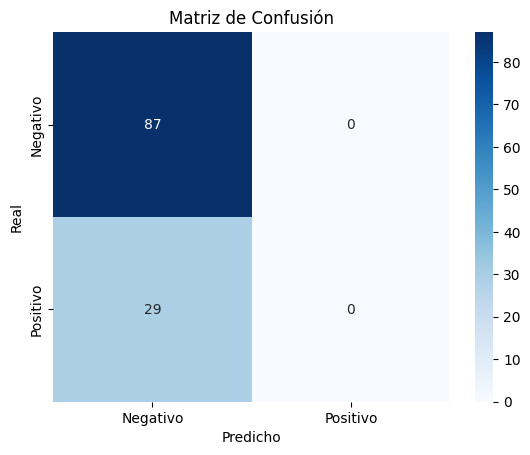

In [122]:
# Matriz de confusión ya calculada como `cm`
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Support vector machine

In [124]:
from sklearn.svm import LinearSVC
start_time = time.time()

model = LinearSVC()
model.fit(X_train_tfidf, y_train)

end_time = time.time()
print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 0.0156 seconds


In [125]:
y_pred = model.predict(X_test_tfidf)
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

In [126]:
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score     support
accept         0.851064  0.919540  0.883978   87.000000
reject         0.681818  0.517241  0.588235   29.000000
accuracy       0.818966  0.818966  0.818966    0.818966
macro avg      0.766441  0.718391  0.736107  116.000000
weighted avg   0.808752  0.818966  0.810042  116.000000


## Interpretación

Métricas por clase

Estas muestran el rendimiento para cada clase (aceptación y rechazo):

### Aceptado
Precisión (0,85): De todos los casos de "aceptación" previstos, el 85,1 % fueron correctos.

Recall (0,92): De todos los casos de "aceptación" reales, el 91,95 % se predijeron correctamente.

F1 Score (0,88): Media armónica de precisión y recuperación. Buen equilibrio.

Support (87): Hubo 87 ejemplos de "aceptación" reales.

### Rechazado
Precisión (0,68): De todos los casos de "rechazo" previstos, el 68,2 % fueron correctos.

Recall (0,52): De todos los casos de "rechazo" reales, solo el 51,7 % se predijeron correctamente.

Puntuación F1 (0,59): Rendimiento inferior en esta clase.

Support (29): Hubo 29 ejemplos de "rechazo" reales.

Métricas generales
Precisión (0,82): El 81,9 % de todas las predicciones (independientemente de la clase) fueron correctas.

Promedio macro: Promedio de la precisión, la recuperación y la puntuación F1 para todas las clases sin ponderar por el apoyo.
Esto es más sensible al rendimiento en clases subrepresentadas (p. ej., rechazo).

Promedio ponderado. Igual que el macro, pero ponderado por el número de instancias verdaderas por clase (apoyo).
Por lo tanto, la aceptación contribuye más porque hay más ejemplos.

El modelo funciona bien al identificar casos de "aceptación", pero tiene dificultades con los de "rechazo". Probablemente, esto se deba a un desequilibrio de clases (menos casos de rechazo) o a que las características no son suficientes para separar las clases claramente.

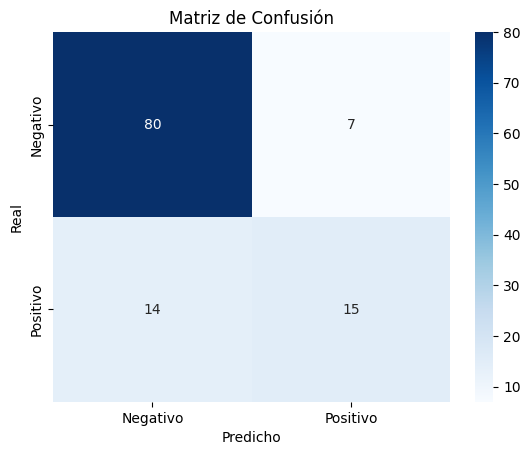

In [127]:
# Matriz de confusión ya calculada como `cm`
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Random forest

In [128]:
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()

model = RandomForestClassifier()
model.fit(X_train_tfidf, y_train)

end_time = time.time()
print(f"Training time: {end_time - start_time:.4f} seconds")


Training time: 0.2763 seconds


In [129]:
y_pred = model.predict(X_test_tfidf)
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

In [130]:
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score     support
accept         0.763158  1.000000  0.865672   87.000000
reject         1.000000  0.068966  0.129032   29.000000
accuracy       0.767241  0.767241  0.767241    0.767241
macro avg      0.881579  0.534483  0.497352  116.000000
weighted avg   0.822368  0.767241  0.681512  116.000000


## Interpretación
Métricas por clase

### Aceptado

Precisión: 0,76 – Aproximadamente el 76 % de los casos de "aceptación" previstos son correctos.

Recall: 1,00 – Encuentra correctamente todos los casos de "aceptación" reales.

Puntuación F1: 0,87 – Alta, debido a un recuerdo perfecto.

### Rechazado
Precisión: 1,00 – Cada vez que el modelo predice "rechazar", acierta, pero...

Recall: 0,07 – Detecta solo aproximadamente el 7 % de los casos de "rechazo" reales.

Puntuación F1: 0,13 – Baja, ya que omite la mayoría de los casos de "rechazo".

Rendimiento general
Precisión: 0,77 – El 77 % de todas las predicciones son correctas, principalmente debido a la correcta predicción de "aceptación".

Promedio macro (trata ambas clases por igual):

Muestra un desequilibrio en el rendimiento (recuperación = 0,53, F1 = 0,50).

Promedio ponderado (considera la frecuencia de apoyo/clase):

Refleja un rendimiento sesgado: decente en general, pero un rendimiento inferior en la clase minoritaria reduce F1.

Qué significa:
Su modelo favorece considerablemente la "aceptación", probablemente debido al desequilibrio de clases.

Rara vez identifica "rechazo", aunque su precisión es perfecta cuando lo hace.

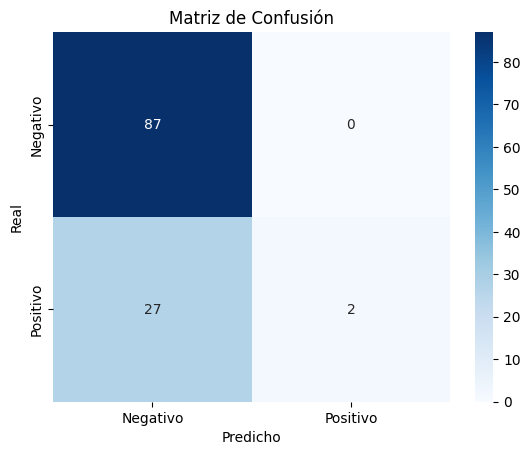

In [131]:
# Matriz de confusión ya calculada como `cm`
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()